# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [31]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

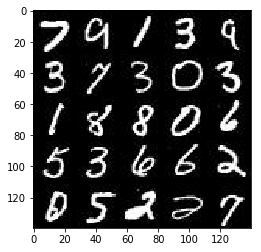

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

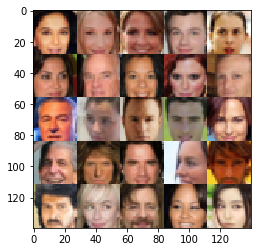

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels ), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="lr")


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [89]:
def leaky_relu(z, name=None):
    return tf.maximum(z,0.1 * z,  name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [149]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        dropout = 1 - 0.60
        x1 = tf.layers.conv2d(images, 64, 3, strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False, activation=None)
        #leaky relu
        relu1 = leaky_relu(x1)
        relu1 = tf.nn.dropout(x1, dropout)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False, activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        #leaky relu
        relu2 = leaky_relu(bn2)
        relu2 = tf.nn.dropout(relu2, dropout)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False, activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        #leaky relu
        relu3 = leaky_relu(bn3)
        relu3 = tf.nn.dropout(relu3, dropout)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [150]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024,use_bias=False, activation=None)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 3, strides=2, padding='same',use_bias=False, activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x128 now
       
        x3 = tf.layers.conv2d_transpose(x2, 256, 3, strides=2, padding='same',use_bias=False, activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x2 = leaky_relu(x2)
        #28x28x64
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28, 28))
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [151]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [152]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
   # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)   
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [153]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [154]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={lr:learning_rate, input_real:batch_images , input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr: learning_rate,input_real:batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr: learning_rate,input_real:batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,20, input_z, data_shape[3], data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 Discriminator Loss: 1.1245... Generator Loss: 4.4183
Epoch 1/2... Step 20 Discriminator Loss: 3.3798... Generator Loss: 4.0990
Epoch 1/2... Step 30 Discriminator Loss: 2.7516... Generator Loss: 3.6178
Epoch 1/2... Step 40 Discriminator Loss: 1.9908... Generator Loss: 3.0149
Epoch 1/2... Step 50 Discriminator Loss: 2.3656... Generator Loss: 2.5545
Epoch 1/2... Step 60 Discriminator Loss: 2.1806... Generator Loss: 2.3285
Epoch 1/2... Step 70 Discriminator Loss: 1.5953... Generator Loss: 2.0096
Epoch 1/2... Step 80 Discriminator Loss: 1.6302... Generator Loss: 1.9138
Epoch 1/2... Step 90 Discriminator Loss: 1.3272... Generator Loss: 1.4094
Epoch 1/2... Step 100 Discriminator Loss: 1.5744... Generator Loss: 1.3609


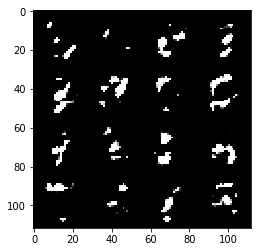

Epoch 1/2... Step 110 Discriminator Loss: 1.8243... Generator Loss: 2.3242
Epoch 1/2... Step 120 Discriminator Loss: 1.2581... Generator Loss: 1.3172
Epoch 1/2... Step 130 Discriminator Loss: 1.2131... Generator Loss: 1.2308
Epoch 1/2... Step 140 Discriminator Loss: 2.0483... Generator Loss: 0.2478
Epoch 1/2... Step 150 Discriminator Loss: 1.4526... Generator Loss: 0.6688
Epoch 1/2... Step 160 Discriminator Loss: 1.5122... Generator Loss: 0.4751
Epoch 1/2... Step 170 Discriminator Loss: 1.4265... Generator Loss: 0.5356
Epoch 1/2... Step 180 Discriminator Loss: 1.3906... Generator Loss: 0.5799
Epoch 1/2... Step 190 Discriminator Loss: 1.2011... Generator Loss: 1.1199
Epoch 1/2... Step 200 Discriminator Loss: 1.1285... Generator Loss: 0.8524


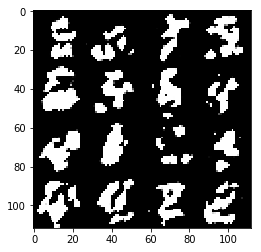

Epoch 1/2... Step 210 Discriminator Loss: 0.9171... Generator Loss: 1.3112
Epoch 1/2... Step 220 Discriminator Loss: 1.4458... Generator Loss: 0.5654
Epoch 1/2... Step 230 Discriminator Loss: 1.6463... Generator Loss: 2.0794
Epoch 1/2... Step 240 Discriminator Loss: 1.1248... Generator Loss: 1.8380
Epoch 1/2... Step 250 Discriminator Loss: 1.1933... Generator Loss: 1.1252
Epoch 1/2... Step 260 Discriminator Loss: 1.1200... Generator Loss: 1.1359
Epoch 1/2... Step 270 Discriminator Loss: 0.9472... Generator Loss: 1.5279
Epoch 1/2... Step 280 Discriminator Loss: 1.4273... Generator Loss: 0.6555
Epoch 1/2... Step 290 Discriminator Loss: 1.2506... Generator Loss: 3.1692
Epoch 1/2... Step 300 Discriminator Loss: 1.7679... Generator Loss: 0.3877


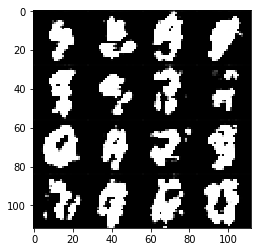

Epoch 1/2... Step 310 Discriminator Loss: 0.8692... Generator Loss: 1.8544
Epoch 1/2... Step 320 Discriminator Loss: 0.8917... Generator Loss: 1.7251
Epoch 1/2... Step 330 Discriminator Loss: 0.7999... Generator Loss: 1.7016
Epoch 1/2... Step 340 Discriminator Loss: 1.7974... Generator Loss: 0.3773
Epoch 1/2... Step 350 Discriminator Loss: 0.8338... Generator Loss: 1.5023
Epoch 1/2... Step 360 Discriminator Loss: 1.4035... Generator Loss: 0.5236
Epoch 1/2... Step 370 Discriminator Loss: 1.2106... Generator Loss: 2.4336
Epoch 1/2... Step 380 Discriminator Loss: 0.9753... Generator Loss: 1.4443
Epoch 1/2... Step 390 Discriminator Loss: 0.9131... Generator Loss: 2.7807
Epoch 1/2... Step 400 Discriminator Loss: 1.2608... Generator Loss: 0.9879


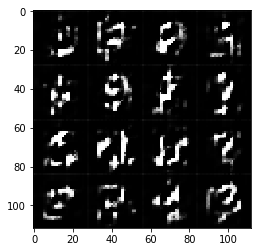

Epoch 1/2... Step 410 Discriminator Loss: 1.3788... Generator Loss: 0.7672
Epoch 1/2... Step 420 Discriminator Loss: 1.3846... Generator Loss: 0.8608
Epoch 1/2... Step 430 Discriminator Loss: 1.6606... Generator Loss: 0.6389
Epoch 1/2... Step 440 Discriminator Loss: 1.5184... Generator Loss: 0.6220
Epoch 1/2... Step 450 Discriminator Loss: 1.4646... Generator Loss: 0.6676
Epoch 1/2... Step 460 Discriminator Loss: 1.5727... Generator Loss: 0.5845
Epoch 1/2... Step 470 Discriminator Loss: 1.4070... Generator Loss: 0.8845
Epoch 1/2... Step 480 Discriminator Loss: 1.5585... Generator Loss: 0.8697
Epoch 1/2... Step 490 Discriminator Loss: 1.4685... Generator Loss: 0.9563
Epoch 1/2... Step 500 Discriminator Loss: 1.4339... Generator Loss: 0.7754


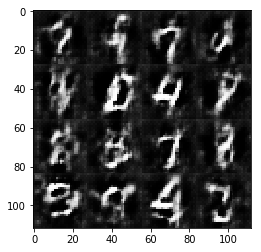

Epoch 1/2... Step 510 Discriminator Loss: 1.5040... Generator Loss: 0.8968
Epoch 1/2... Step 520 Discriminator Loss: 1.4492... Generator Loss: 0.7757
Epoch 1/2... Step 530 Discriminator Loss: 1.4414... Generator Loss: 0.7679
Epoch 1/2... Step 540 Discriminator Loss: 1.3810... Generator Loss: 0.9448
Epoch 1/2... Step 550 Discriminator Loss: 1.4987... Generator Loss: 1.1217
Epoch 1/2... Step 560 Discriminator Loss: 1.5271... Generator Loss: 0.6219
Epoch 1/2... Step 570 Discriminator Loss: 1.5547... Generator Loss: 0.7550
Epoch 1/2... Step 580 Discriminator Loss: 1.3643... Generator Loss: 0.8573
Epoch 1/2... Step 590 Discriminator Loss: 1.4468... Generator Loss: 0.6316
Epoch 1/2... Step 600 Discriminator Loss: 1.3539... Generator Loss: 0.8186


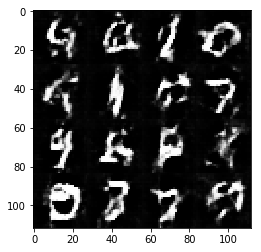

Epoch 1/2... Step 610 Discriminator Loss: 1.4541... Generator Loss: 0.7108
Epoch 1/2... Step 620 Discriminator Loss: 1.3921... Generator Loss: 0.6450
Epoch 1/2... Step 630 Discriminator Loss: 1.4671... Generator Loss: 0.9113
Epoch 1/2... Step 640 Discriminator Loss: 1.4575... Generator Loss: 0.9053
Epoch 1/2... Step 650 Discriminator Loss: 1.5581... Generator Loss: 1.0830
Epoch 1/2... Step 660 Discriminator Loss: 1.4311... Generator Loss: 0.7406
Epoch 1/2... Step 670 Discriminator Loss: 1.4558... Generator Loss: 0.7675
Epoch 1/2... Step 680 Discriminator Loss: 1.3667... Generator Loss: 0.8248
Epoch 1/2... Step 690 Discriminator Loss: 1.5297... Generator Loss: 0.8787
Epoch 1/2... Step 700 Discriminator Loss: 1.4866... Generator Loss: 0.8253


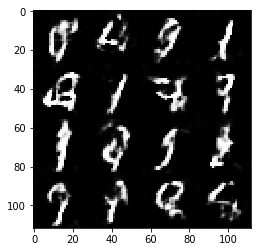

Epoch 1/2... Step 710 Discriminator Loss: 1.4721... Generator Loss: 0.6136
Epoch 1/2... Step 720 Discriminator Loss: 1.4773... Generator Loss: 0.7160
Epoch 1/2... Step 730 Discriminator Loss: 1.3773... Generator Loss: 0.6834
Epoch 1/2... Step 740 Discriminator Loss: 1.4007... Generator Loss: 0.9500
Epoch 1/2... Step 750 Discriminator Loss: 1.4673... Generator Loss: 0.8232
Epoch 1/2... Step 760 Discriminator Loss: 1.4563... Generator Loss: 0.8164
Epoch 1/2... Step 770 Discriminator Loss: 1.5268... Generator Loss: 0.7023
Epoch 1/2... Step 780 Discriminator Loss: 1.3877... Generator Loss: 0.9697
Epoch 1/2... Step 790 Discriminator Loss: 1.4130... Generator Loss: 0.6329
Epoch 1/2... Step 800 Discriminator Loss: 1.5123... Generator Loss: 0.6801


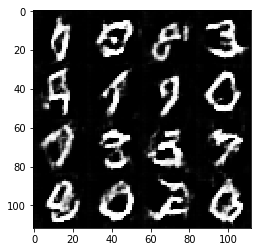

Epoch 1/2... Step 810 Discriminator Loss: 1.4605... Generator Loss: 0.8899
Epoch 1/2... Step 820 Discriminator Loss: 1.4456... Generator Loss: 0.6942
Epoch 1/2... Step 830 Discriminator Loss: 1.4411... Generator Loss: 0.9412
Epoch 1/2... Step 840 Discriminator Loss: 1.3814... Generator Loss: 0.9167
Epoch 1/2... Step 850 Discriminator Loss: 1.3685... Generator Loss: 0.7532
Epoch 1/2... Step 860 Discriminator Loss: 1.3458... Generator Loss: 0.7647
Epoch 1/2... Step 870 Discriminator Loss: 1.4796... Generator Loss: 0.7553
Epoch 1/2... Step 880 Discriminator Loss: 1.4241... Generator Loss: 0.9772
Epoch 1/2... Step 890 Discriminator Loss: 1.4252... Generator Loss: 0.9242
Epoch 1/2... Step 900 Discriminator Loss: 1.4523... Generator Loss: 0.5980


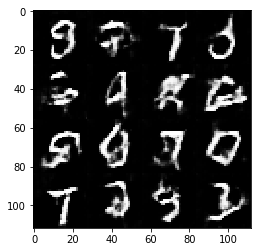

Epoch 1/2... Step 910 Discriminator Loss: 1.4182... Generator Loss: 0.8367
Epoch 1/2... Step 920 Discriminator Loss: 1.3468... Generator Loss: 0.8962
Epoch 1/2... Step 930 Discriminator Loss: 1.4146... Generator Loss: 0.9471
Epoch 2/2... Step 940 Discriminator Loss: 1.4377... Generator Loss: 0.7329
Epoch 2/2... Step 950 Discriminator Loss: 1.4691... Generator Loss: 0.5041
Epoch 2/2... Step 960 Discriminator Loss: 1.4359... Generator Loss: 0.8989
Epoch 2/2... Step 970 Discriminator Loss: 1.3700... Generator Loss: 0.8007
Epoch 2/2... Step 980 Discriminator Loss: 1.2808... Generator Loss: 0.8155
Epoch 2/2... Step 990 Discriminator Loss: 1.4466... Generator Loss: 0.7932
Epoch 2/2... Step 1000 Discriminator Loss: 1.3918... Generator Loss: 0.6442


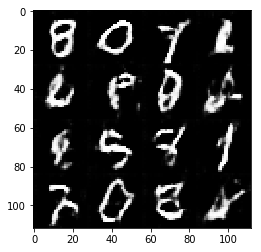

Epoch 2/2... Step 1010 Discriminator Loss: 1.4109... Generator Loss: 0.7656
Epoch 2/2... Step 1020 Discriminator Loss: 1.3878... Generator Loss: 0.7730
Epoch 2/2... Step 1030 Discriminator Loss: 1.4481... Generator Loss: 0.7117
Epoch 2/2... Step 1040 Discriminator Loss: 1.4457... Generator Loss: 0.8781
Epoch 2/2... Step 1050 Discriminator Loss: 1.3289... Generator Loss: 0.8186
Epoch 2/2... Step 1060 Discriminator Loss: 1.4804... Generator Loss: 0.6167
Epoch 2/2... Step 1070 Discriminator Loss: 1.3497... Generator Loss: 0.7771
Epoch 2/2... Step 1080 Discriminator Loss: 1.4379... Generator Loss: 0.7505
Epoch 2/2... Step 1090 Discriminator Loss: 1.3753... Generator Loss: 0.5506
Epoch 2/2... Step 1100 Discriminator Loss: 1.4932... Generator Loss: 0.5898


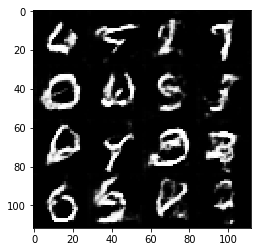

Epoch 2/2... Step 1110 Discriminator Loss: 1.3636... Generator Loss: 0.7335
Epoch 2/2... Step 1120 Discriminator Loss: 1.3574... Generator Loss: 0.7774
Epoch 2/2... Step 1130 Discriminator Loss: 1.4639... Generator Loss: 0.7311
Epoch 2/2... Step 1140 Discriminator Loss: 1.3533... Generator Loss: 0.9658
Epoch 2/2... Step 1150 Discriminator Loss: 1.3981... Generator Loss: 0.6690
Epoch 2/2... Step 1160 Discriminator Loss: 1.3976... Generator Loss: 0.9512
Epoch 2/2... Step 1170 Discriminator Loss: 1.4315... Generator Loss: 0.7942
Epoch 2/2... Step 1180 Discriminator Loss: 1.4096... Generator Loss: 0.8197
Epoch 2/2... Step 1190 Discriminator Loss: 1.3706... Generator Loss: 0.7681
Epoch 2/2... Step 1200 Discriminator Loss: 1.3399... Generator Loss: 0.8219


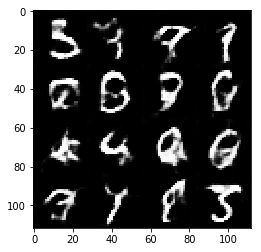

Epoch 2/2... Step 1210 Discriminator Loss: 1.3185... Generator Loss: 0.9895
Epoch 2/2... Step 1220 Discriminator Loss: 1.4128... Generator Loss: 0.6814
Epoch 2/2... Step 1230 Discriminator Loss: 1.5313... Generator Loss: 0.8485
Epoch 2/2... Step 1240 Discriminator Loss: 1.5219... Generator Loss: 1.0391
Epoch 2/2... Step 1250 Discriminator Loss: 1.4439... Generator Loss: 0.6443
Epoch 2/2... Step 1260 Discriminator Loss: 1.3746... Generator Loss: 0.8337
Epoch 2/2... Step 1270 Discriminator Loss: 1.4191... Generator Loss: 0.7849
Epoch 2/2... Step 1280 Discriminator Loss: 1.4369... Generator Loss: 0.8659
Epoch 2/2... Step 1290 Discriminator Loss: 1.4731... Generator Loss: 0.7281
Epoch 2/2... Step 1300 Discriminator Loss: 1.4266... Generator Loss: 0.5909


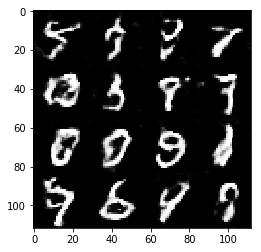

Epoch 2/2... Step 1310 Discriminator Loss: 1.4459... Generator Loss: 0.7025
Epoch 2/2... Step 1320 Discriminator Loss: 1.3521... Generator Loss: 0.9041
Epoch 2/2... Step 1330 Discriminator Loss: 1.4473... Generator Loss: 0.6183
Epoch 2/2... Step 1340 Discriminator Loss: 1.4942... Generator Loss: 0.6972
Epoch 2/2... Step 1350 Discriminator Loss: 1.3817... Generator Loss: 0.8398
Epoch 2/2... Step 1360 Discriminator Loss: 1.4062... Generator Loss: 0.6645
Epoch 2/2... Step 1370 Discriminator Loss: 1.3923... Generator Loss: 0.6867
Epoch 2/2... Step 1380 Discriminator Loss: 1.3987... Generator Loss: 0.7604
Epoch 2/2... Step 1390 Discriminator Loss: 1.4363... Generator Loss: 0.7686
Epoch 2/2... Step 1400 Discriminator Loss: 1.5607... Generator Loss: 0.8861


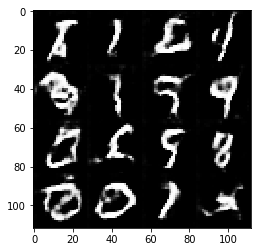

Epoch 2/2... Step 1410 Discriminator Loss: 1.4320... Generator Loss: 1.1324
Epoch 2/2... Step 1420 Discriminator Loss: 1.4020... Generator Loss: 0.7831
Epoch 2/2... Step 1430 Discriminator Loss: 1.3274... Generator Loss: 1.0468
Epoch 2/2... Step 1440 Discriminator Loss: 1.3622... Generator Loss: 0.6141
Epoch 2/2... Step 1450 Discriminator Loss: 1.3658... Generator Loss: 0.6831
Epoch 2/2... Step 1460 Discriminator Loss: 1.2863... Generator Loss: 0.8375
Epoch 2/2... Step 1470 Discriminator Loss: 1.3280... Generator Loss: 0.8862
Epoch 2/2... Step 1480 Discriminator Loss: 1.4565... Generator Loss: 1.0084
Epoch 2/2... Step 1490 Discriminator Loss: 1.3651... Generator Loss: 0.8080
Epoch 2/2... Step 1500 Discriminator Loss: 1.3601... Generator Loss: 0.7281


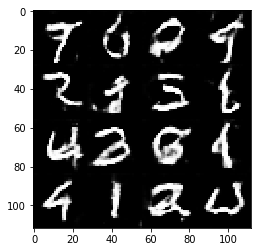

Epoch 2/2... Step 1510 Discriminator Loss: 1.4037... Generator Loss: 1.0050
Epoch 2/2... Step 1520 Discriminator Loss: 1.4235... Generator Loss: 0.6952
Epoch 2/2... Step 1530 Discriminator Loss: 1.3641... Generator Loss: 0.7779
Epoch 2/2... Step 1540 Discriminator Loss: 1.3427... Generator Loss: 0.8195
Epoch 2/2... Step 1550 Discriminator Loss: 1.3988... Generator Loss: 0.7171
Epoch 2/2... Step 1560 Discriminator Loss: 1.5045... Generator Loss: 0.7106
Epoch 2/2... Step 1570 Discriminator Loss: 1.4097... Generator Loss: 0.8703
Epoch 2/2... Step 1580 Discriminator Loss: 1.4783... Generator Loss: 0.5823
Epoch 2/2... Step 1590 Discriminator Loss: 1.3014... Generator Loss: 0.7700
Epoch 2/2... Step 1600 Discriminator Loss: 1.4097... Generator Loss: 0.9210


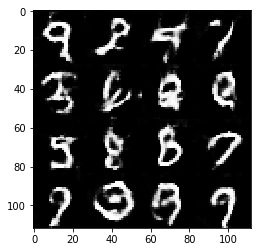

Epoch 2/2... Step 1610 Discriminator Loss: 1.4161... Generator Loss: 0.8088
Epoch 2/2... Step 1620 Discriminator Loss: 1.5131... Generator Loss: 0.6882
Epoch 2/2... Step 1630 Discriminator Loss: 1.4025... Generator Loss: 0.6662
Epoch 2/2... Step 1640 Discriminator Loss: 1.3576... Generator Loss: 0.9281
Epoch 2/2... Step 1650 Discriminator Loss: 1.4062... Generator Loss: 0.7667
Epoch 2/2... Step 1660 Discriminator Loss: 1.4579... Generator Loss: 0.8658
Epoch 2/2... Step 1670 Discriminator Loss: 1.4097... Generator Loss: 0.6765
Epoch 2/2... Step 1680 Discriminator Loss: 1.4027... Generator Loss: 0.9076
Epoch 2/2... Step 1690 Discriminator Loss: 1.3714... Generator Loss: 0.7323
Epoch 2/2... Step 1700 Discriminator Loss: 1.2691... Generator Loss: 0.9494


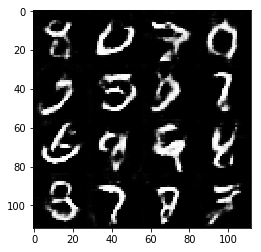

Epoch 2/2... Step 1710 Discriminator Loss: 1.4603... Generator Loss: 0.7848
Epoch 2/2... Step 1720 Discriminator Loss: 1.4216... Generator Loss: 0.6585
Epoch 2/2... Step 1730 Discriminator Loss: 1.3246... Generator Loss: 0.7659
Epoch 2/2... Step 1740 Discriminator Loss: 1.5109... Generator Loss: 0.5562
Epoch 2/2... Step 1750 Discriminator Loss: 1.4283... Generator Loss: 0.8500
Epoch 2/2... Step 1760 Discriminator Loss: 1.4368... Generator Loss: 0.9354
Epoch 2/2... Step 1770 Discriminator Loss: 1.3245... Generator Loss: 1.0279
Epoch 2/2... Step 1780 Discriminator Loss: 1.3840... Generator Loss: 0.7728
Epoch 2/2... Step 1790 Discriminator Loss: 1.3915... Generator Loss: 0.7660
Epoch 2/2... Step 1800 Discriminator Loss: 1.3852... Generator Loss: 0.7923


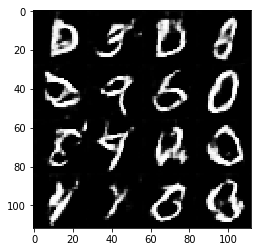

Epoch 2/2... Step 1810 Discriminator Loss: 1.2964... Generator Loss: 0.9130
Epoch 2/2... Step 1820 Discriminator Loss: 1.3219... Generator Loss: 0.9381
Epoch 2/2... Step 1830 Discriminator Loss: 1.4736... Generator Loss: 0.9037
Epoch 2/2... Step 1840 Discriminator Loss: 1.3518... Generator Loss: 0.7402
Epoch 2/2... Step 1850 Discriminator Loss: 1.4581... Generator Loss: 1.1198
Epoch 2/2... Step 1860 Discriminator Loss: 1.3400... Generator Loss: 0.9677
Epoch 2/2... Step 1870 Discriminator Loss: 1.3180... Generator Loss: 0.9687


In [155]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 1.3924... Generator Loss: 2.3828
Epoch 1/1... Step 20 Discriminator Loss: 4.0365... Generator Loss: 8.3881
Epoch 1/1... Step 30 Discriminator Loss: 2.1766... Generator Loss: 5.4379
Epoch 1/1... Step 40 Discriminator Loss: 5.1687... Generator Loss: 7.6752
Epoch 1/1... Step 50 Discriminator Loss: 1.3656... Generator Loss: 4.5258
Epoch 1/1... Step 60 Discriminator Loss: 1.6207... Generator Loss: 4.8659
Epoch 1/1... Step 70 Discriminator Loss: 1.3522... Generator Loss: 4.2539
Epoch 1/1... Step 80 Discriminator Loss: 0.6058... Generator Loss: 2.6860
Epoch 1/1... Step 90 Discriminator Loss: 0.7204... Generator Loss: 1.6809
Epoch 1/1... Step 100 Discriminator Loss: 2.4027... Generator Loss: 0.2436


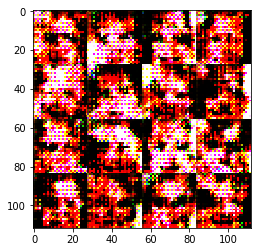

Epoch 1/1... Step 110 Discriminator Loss: 0.6023... Generator Loss: 2.5458
Epoch 1/1... Step 120 Discriminator Loss: 3.8675... Generator Loss: 0.0909
Epoch 1/1... Step 130 Discriminator Loss: 0.9587... Generator Loss: 2.4725
Epoch 1/1... Step 140 Discriminator Loss: 1.8867... Generator Loss: 2.2164
Epoch 1/1... Step 150 Discriminator Loss: 1.8926... Generator Loss: 2.3006
Epoch 1/1... Step 160 Discriminator Loss: 2.5643... Generator Loss: 1.9934
Epoch 1/1... Step 170 Discriminator Loss: 1.5542... Generator Loss: 1.0078
Epoch 1/1... Step 180 Discriminator Loss: 1.4526... Generator Loss: 0.7792
Epoch 1/1... Step 190 Discriminator Loss: 1.5859... Generator Loss: 0.5320
Epoch 1/1... Step 200 Discriminator Loss: 1.6507... Generator Loss: 0.5222


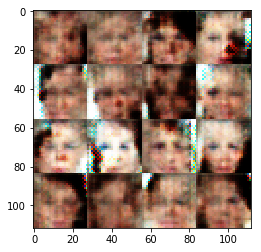

Epoch 1/1... Step 210 Discriminator Loss: 1.7332... Generator Loss: 0.4505
Epoch 1/1... Step 220 Discriminator Loss: 1.4992... Generator Loss: 0.8416
Epoch 1/1... Step 230 Discriminator Loss: 1.5435... Generator Loss: 0.8016
Epoch 1/1... Step 240 Discriminator Loss: 1.5567... Generator Loss: 0.5218
Epoch 1/1... Step 250 Discriminator Loss: 1.7574... Generator Loss: 0.4883
Epoch 1/1... Step 260 Discriminator Loss: 1.6556... Generator Loss: 0.5107
Epoch 1/1... Step 270 Discriminator Loss: 1.5546... Generator Loss: 1.0321
Epoch 1/1... Step 280 Discriminator Loss: 1.5355... Generator Loss: 0.8803
Epoch 1/1... Step 290 Discriminator Loss: 1.4589... Generator Loss: 0.8228
Epoch 1/1... Step 300 Discriminator Loss: 1.5068... Generator Loss: 0.9466


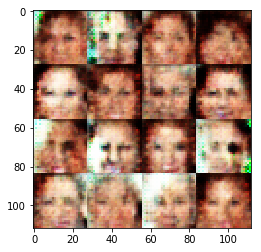

Epoch 1/1... Step 310 Discriminator Loss: 1.5291... Generator Loss: 0.7839
Epoch 1/1... Step 320 Discriminator Loss: 1.5504... Generator Loss: 0.9571
Epoch 1/1... Step 330 Discriminator Loss: 1.5527... Generator Loss: 0.6406
Epoch 1/1... Step 340 Discriminator Loss: 1.4942... Generator Loss: 0.6210
Epoch 1/1... Step 350 Discriminator Loss: 1.4865... Generator Loss: 0.6819
Epoch 1/1... Step 360 Discriminator Loss: 1.4719... Generator Loss: 0.7645
Epoch 1/1... Step 370 Discriminator Loss: 1.5129... Generator Loss: 0.6447
Epoch 1/1... Step 380 Discriminator Loss: 1.4395... Generator Loss: 0.8334
Epoch 1/1... Step 390 Discriminator Loss: 1.4484... Generator Loss: 0.7605
Epoch 1/1... Step 400 Discriminator Loss: 1.4644... Generator Loss: 0.8507


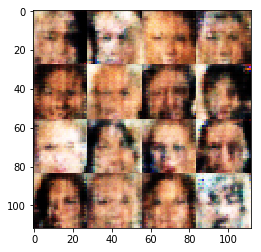

Epoch 1/1... Step 410 Discriminator Loss: 1.4353... Generator Loss: 0.8764
Epoch 1/1... Step 420 Discriminator Loss: 1.4101... Generator Loss: 0.8664
Epoch 1/1... Step 430 Discriminator Loss: 1.4838... Generator Loss: 0.6832
Epoch 1/1... Step 440 Discriminator Loss: 1.4405... Generator Loss: 0.8686
Epoch 1/1... Step 450 Discriminator Loss: 1.4475... Generator Loss: 0.7693
Epoch 1/1... Step 460 Discriminator Loss: 1.4269... Generator Loss: 0.7529
Epoch 1/1... Step 470 Discriminator Loss: 1.4951... Generator Loss: 0.7015
Epoch 1/1... Step 480 Discriminator Loss: 1.5474... Generator Loss: 0.7886
Epoch 1/1... Step 490 Discriminator Loss: 1.5522... Generator Loss: 0.7362
Epoch 1/1... Step 500 Discriminator Loss: 1.5141... Generator Loss: 0.7706


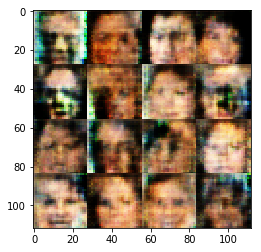

Epoch 1/1... Step 510 Discriminator Loss: 1.4606... Generator Loss: 0.7847
Epoch 1/1... Step 520 Discriminator Loss: 1.3980... Generator Loss: 0.7086
Epoch 1/1... Step 530 Discriminator Loss: 1.4872... Generator Loss: 0.7305
Epoch 1/1... Step 540 Discriminator Loss: 1.5032... Generator Loss: 0.8328
Epoch 1/1... Step 550 Discriminator Loss: 1.4378... Generator Loss: 0.6790
Epoch 1/1... Step 560 Discriminator Loss: 1.4986... Generator Loss: 0.8661
Epoch 1/1... Step 570 Discriminator Loss: 1.4179... Generator Loss: 0.7198
Epoch 1/1... Step 580 Discriminator Loss: 1.4057... Generator Loss: 0.7980
Epoch 1/1... Step 590 Discriminator Loss: 1.4483... Generator Loss: 0.7761
Epoch 1/1... Step 600 Discriminator Loss: 1.4335... Generator Loss: 0.7825


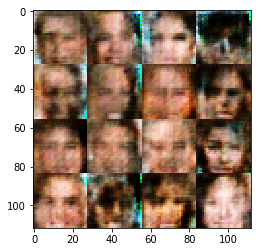

Epoch 1/1... Step 610 Discriminator Loss: 1.4514... Generator Loss: 0.8530
Epoch 1/1... Step 620 Discriminator Loss: 1.4497... Generator Loss: 0.7368
Epoch 1/1... Step 630 Discriminator Loss: 1.4175... Generator Loss: 0.7557
Epoch 1/1... Step 640 Discriminator Loss: 1.4109... Generator Loss: 0.8709
Epoch 1/1... Step 650 Discriminator Loss: 1.4592... Generator Loss: 0.7455
Epoch 1/1... Step 660 Discriminator Loss: 1.4297... Generator Loss: 0.8146
Epoch 1/1... Step 670 Discriminator Loss: 1.5112... Generator Loss: 0.7278
Epoch 1/1... Step 680 Discriminator Loss: 1.4627... Generator Loss: 0.7071
Epoch 1/1... Step 690 Discriminator Loss: 1.4436... Generator Loss: 0.7483
Epoch 1/1... Step 700 Discriminator Loss: 1.4556... Generator Loss: 0.7393


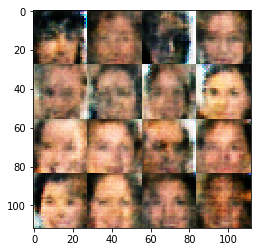

Epoch 1/1... Step 710 Discriminator Loss: 1.4243... Generator Loss: 0.7791
Epoch 1/1... Step 720 Discriminator Loss: 1.3968... Generator Loss: 0.9221
Epoch 1/1... Step 730 Discriminator Loss: 1.4284... Generator Loss: 0.8425
Epoch 1/1... Step 740 Discriminator Loss: 1.4239... Generator Loss: 0.7946
Epoch 1/1... Step 750 Discriminator Loss: 1.4031... Generator Loss: 0.7718
Epoch 1/1... Step 760 Discriminator Loss: 1.4435... Generator Loss: 0.7487
Epoch 1/1... Step 770 Discriminator Loss: 1.4323... Generator Loss: 0.7983
Epoch 1/1... Step 780 Discriminator Loss: 1.4094... Generator Loss: 0.7843
Epoch 1/1... Step 790 Discriminator Loss: 1.3865... Generator Loss: 0.7608
Epoch 1/1... Step 800 Discriminator Loss: 1.4105... Generator Loss: 0.7346


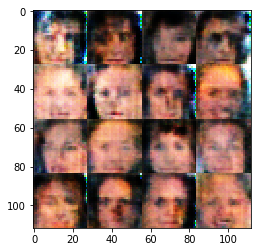

Epoch 1/1... Step 810 Discriminator Loss: 1.4104... Generator Loss: 0.7619
Epoch 1/1... Step 820 Discriminator Loss: 1.4009... Generator Loss: 0.8070
Epoch 1/1... Step 830 Discriminator Loss: 1.4097... Generator Loss: 0.8609
Epoch 1/1... Step 840 Discriminator Loss: 1.4043... Generator Loss: 0.7443
Epoch 1/1... Step 850 Discriminator Loss: 1.4076... Generator Loss: 0.7579
Epoch 1/1... Step 860 Discriminator Loss: 1.4120... Generator Loss: 0.7489
Epoch 1/1... Step 870 Discriminator Loss: 1.4279... Generator Loss: 0.8152
Epoch 1/1... Step 880 Discriminator Loss: 1.3984... Generator Loss: 0.7409
Epoch 1/1... Step 890 Discriminator Loss: 1.4101... Generator Loss: 0.8355
Epoch 1/1... Step 900 Discriminator Loss: 1.4210... Generator Loss: 0.8332


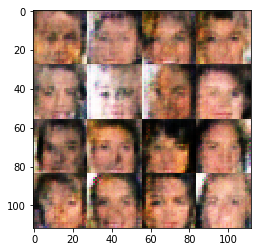

Epoch 1/1... Step 910 Discriminator Loss: 1.4048... Generator Loss: 0.7485
Epoch 1/1... Step 920 Discriminator Loss: 1.4125... Generator Loss: 0.7440
Epoch 1/1... Step 930 Discriminator Loss: 1.4051... Generator Loss: 0.7730
Epoch 1/1... Step 940 Discriminator Loss: 1.3656... Generator Loss: 0.8368
Epoch 1/1... Step 950 Discriminator Loss: 1.4541... Generator Loss: 0.7522
Epoch 1/1... Step 960 Discriminator Loss: 1.4036... Generator Loss: 0.7598
Epoch 1/1... Step 970 Discriminator Loss: 1.3853... Generator Loss: 0.7477
Epoch 1/1... Step 980 Discriminator Loss: 1.4345... Generator Loss: 0.7865
Epoch 1/1... Step 990 Discriminator Loss: 1.4073... Generator Loss: 0.7787
Epoch 1/1... Step 1000 Discriminator Loss: 1.4368... Generator Loss: 0.7586


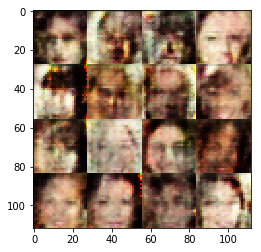

Epoch 1/1... Step 1010 Discriminator Loss: 1.4249... Generator Loss: 0.7672
Epoch 1/1... Step 1020 Discriminator Loss: 1.3898... Generator Loss: 0.8216
Epoch 1/1... Step 1030 Discriminator Loss: 1.4035... Generator Loss: 0.7621
Epoch 1/1... Step 1040 Discriminator Loss: 1.4054... Generator Loss: 0.7899
Epoch 1/1... Step 1050 Discriminator Loss: 1.3900... Generator Loss: 0.7783
Epoch 1/1... Step 1060 Discriminator Loss: 1.3860... Generator Loss: 0.7555
Epoch 1/1... Step 1070 Discriminator Loss: 1.4012... Generator Loss: 0.7804
Epoch 1/1... Step 1080 Discriminator Loss: 1.4342... Generator Loss: 0.7762
Epoch 1/1... Step 1090 Discriminator Loss: 1.4190... Generator Loss: 0.7900
Epoch 1/1... Step 1100 Discriminator Loss: 1.4055... Generator Loss: 0.8449


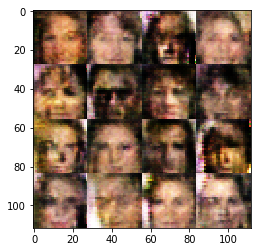

Epoch 1/1... Step 1110 Discriminator Loss: 1.4041... Generator Loss: 0.8042
Epoch 1/1... Step 1120 Discriminator Loss: 1.4070... Generator Loss: 0.8205
Epoch 1/1... Step 1130 Discriminator Loss: 1.4070... Generator Loss: 0.7285
Epoch 1/1... Step 1140 Discriminator Loss: 1.3912... Generator Loss: 0.8197
Epoch 1/1... Step 1150 Discriminator Loss: 1.3886... Generator Loss: 0.7509
Epoch 1/1... Step 1160 Discriminator Loss: 1.3906... Generator Loss: 0.7789
Epoch 1/1... Step 1170 Discriminator Loss: 1.3857... Generator Loss: 0.7924
Epoch 1/1... Step 1180 Discriminator Loss: 1.4071... Generator Loss: 0.7561
Epoch 1/1... Step 1190 Discriminator Loss: 1.4209... Generator Loss: 0.7948
Epoch 1/1... Step 1200 Discriminator Loss: 1.4079... Generator Loss: 0.7895


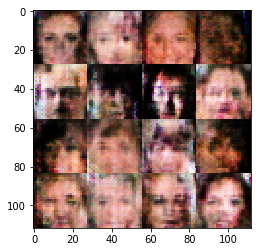

Epoch 1/1... Step 1210 Discriminator Loss: 1.4160... Generator Loss: 0.8039
Epoch 1/1... Step 1220 Discriminator Loss: 1.4007... Generator Loss: 0.7715
Epoch 1/1... Step 1230 Discriminator Loss: 1.4004... Generator Loss: 0.7766
Epoch 1/1... Step 1240 Discriminator Loss: 1.3983... Generator Loss: 0.7893
Epoch 1/1... Step 1250 Discriminator Loss: 1.3876... Generator Loss: 0.7958
Epoch 1/1... Step 1260 Discriminator Loss: 1.3835... Generator Loss: 0.7877
Epoch 1/1... Step 1270 Discriminator Loss: 1.3824... Generator Loss: 0.7888
Epoch 1/1... Step 1280 Discriminator Loss: 1.3706... Generator Loss: 0.7924
Epoch 1/1... Step 1290 Discriminator Loss: 1.4337... Generator Loss: 0.7506
Epoch 1/1... Step 1300 Discriminator Loss: 1.4116... Generator Loss: 0.7923


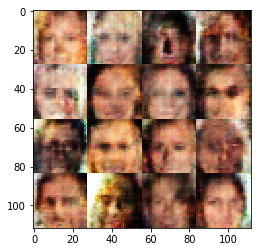

Epoch 1/1... Step 1310 Discriminator Loss: 1.4239... Generator Loss: 0.7703
Epoch 1/1... Step 1320 Discriminator Loss: 1.3948... Generator Loss: 0.7882
Epoch 1/1... Step 1330 Discriminator Loss: 1.3562... Generator Loss: 0.8063
Epoch 1/1... Step 1340 Discriminator Loss: 1.4390... Generator Loss: 0.7608
Epoch 1/1... Step 1350 Discriminator Loss: 1.3978... Generator Loss: 0.8087
Epoch 1/1... Step 1360 Discriminator Loss: 1.4017... Generator Loss: 0.8313
Epoch 1/1... Step 1370 Discriminator Loss: 1.4002... Generator Loss: 0.8159
Epoch 1/1... Step 1380 Discriminator Loss: 1.3981... Generator Loss: 0.7725
Epoch 1/1... Step 1390 Discriminator Loss: 1.4080... Generator Loss: 0.7687
Epoch 1/1... Step 1400 Discriminator Loss: 1.4009... Generator Loss: 0.8140


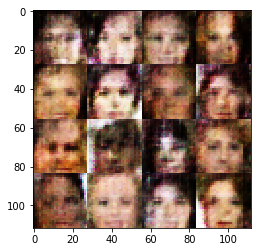

Epoch 1/1... Step 1410 Discriminator Loss: 1.3855... Generator Loss: 0.7360
Epoch 1/1... Step 1420 Discriminator Loss: 1.3509... Generator Loss: 0.7666
Epoch 1/1... Step 1430 Discriminator Loss: 1.3829... Generator Loss: 0.7840
Epoch 1/1... Step 1440 Discriminator Loss: 1.4002... Generator Loss: 0.7757
Epoch 1/1... Step 1450 Discriminator Loss: 1.3867... Generator Loss: 0.8159
Epoch 1/1... Step 1460 Discriminator Loss: 1.3988... Generator Loss: 0.8055
Epoch 1/1... Step 1470 Discriminator Loss: 1.3923... Generator Loss: 0.7993
Epoch 1/1... Step 1480 Discriminator Loss: 1.3798... Generator Loss: 0.8109
Epoch 1/1... Step 1490 Discriminator Loss: 1.3945... Generator Loss: 0.7986
Epoch 1/1... Step 1500 Discriminator Loss: 1.4090... Generator Loss: 0.7780


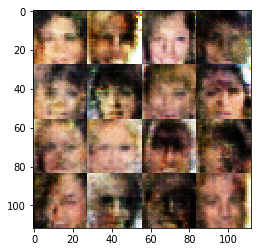

Epoch 1/1... Step 1510 Discriminator Loss: 1.3811... Generator Loss: 0.7764
Epoch 1/1... Step 1520 Discriminator Loss: 1.3723... Generator Loss: 0.7753
Epoch 1/1... Step 1530 Discriminator Loss: 1.3932... Generator Loss: 0.7979
Epoch 1/1... Step 1540 Discriminator Loss: 1.4026... Generator Loss: 0.7745
Epoch 1/1... Step 1550 Discriminator Loss: 1.3649... Generator Loss: 0.7801
Epoch 1/1... Step 1560 Discriminator Loss: 1.4056... Generator Loss: 0.8006
Epoch 1/1... Step 1570 Discriminator Loss: 1.3916... Generator Loss: 0.7998
Epoch 1/1... Step 1580 Discriminator Loss: 1.3743... Generator Loss: 0.8342
Epoch 1/1... Step 1590 Discriminator Loss: 1.3912... Generator Loss: 0.7738
Epoch 1/1... Step 1600 Discriminator Loss: 1.3689... Generator Loss: 0.7892


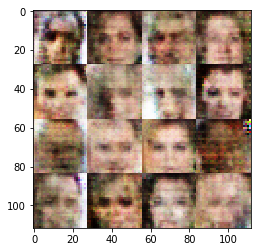

Epoch 1/1... Step 1610 Discriminator Loss: 1.3924... Generator Loss: 0.7793
Epoch 1/1... Step 1620 Discriminator Loss: 1.3832... Generator Loss: 0.8051
Epoch 1/1... Step 1630 Discriminator Loss: 1.4003... Generator Loss: 0.8019
Epoch 1/1... Step 1640 Discriminator Loss: 1.3984... Generator Loss: 0.7719
Epoch 1/1... Step 1650 Discriminator Loss: 1.3907... Generator Loss: 0.8088
Epoch 1/1... Step 1660 Discriminator Loss: 1.3805... Generator Loss: 0.8177
Epoch 1/1... Step 1670 Discriminator Loss: 1.4015... Generator Loss: 0.8014
Epoch 1/1... Step 1680 Discriminator Loss: 1.3888... Generator Loss: 0.7794
Epoch 1/1... Step 1690 Discriminator Loss: 1.3942... Generator Loss: 0.7960
Epoch 1/1... Step 1700 Discriminator Loss: 1.3779... Generator Loss: 0.7965


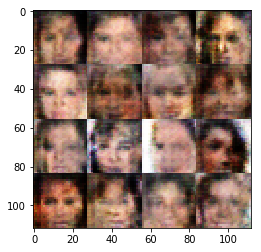

Epoch 1/1... Step 1710 Discriminator Loss: 1.3975... Generator Loss: 0.7874
Epoch 1/1... Step 1720 Discriminator Loss: 1.3927... Generator Loss: 0.8074
Epoch 1/1... Step 1730 Discriminator Loss: 1.3888... Generator Loss: 0.7916
Epoch 1/1... Step 1740 Discriminator Loss: 1.3847... Generator Loss: 0.8090
Epoch 1/1... Step 1750 Discriminator Loss: 1.3944... Generator Loss: 0.8233
Epoch 1/1... Step 1760 Discriminator Loss: 1.3972... Generator Loss: 0.8150
Epoch 1/1... Step 1770 Discriminator Loss: 1.4002... Generator Loss: 0.7819
Epoch 1/1... Step 1780 Discriminator Loss: 1.3727... Generator Loss: 0.7783
Epoch 1/1... Step 1790 Discriminator Loss: 1.3784... Generator Loss: 0.7780
Epoch 1/1... Step 1800 Discriminator Loss: 1.3761... Generator Loss: 0.8232


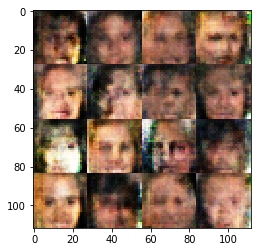

Epoch 1/1... Step 1810 Discriminator Loss: 1.4067... Generator Loss: 0.8037
Epoch 1/1... Step 1820 Discriminator Loss: 1.3908... Generator Loss: 0.8136
Epoch 1/1... Step 1830 Discriminator Loss: 1.3915... Generator Loss: 0.7640
Epoch 1/1... Step 1840 Discriminator Loss: 1.3942... Generator Loss: 0.7956
Epoch 1/1... Step 1850 Discriminator Loss: 1.3781... Generator Loss: 0.7943
Epoch 1/1... Step 1860 Discriminator Loss: 1.3898... Generator Loss: 0.7779
Epoch 1/1... Step 1870 Discriminator Loss: 1.4103... Generator Loss: 0.8048
Epoch 1/1... Step 1880 Discriminator Loss: 1.4114... Generator Loss: 0.7866
Epoch 1/1... Step 1890 Discriminator Loss: 1.3903... Generator Loss: 0.8030
Epoch 1/1... Step 1900 Discriminator Loss: 1.3807... Generator Loss: 0.7881


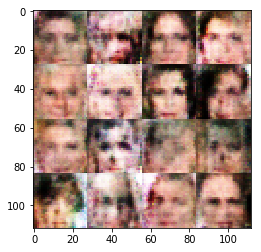

Epoch 1/1... Step 1910 Discriminator Loss: 1.3771... Generator Loss: 0.8006
Epoch 1/1... Step 1920 Discriminator Loss: 1.4000... Generator Loss: 0.7837
Epoch 1/1... Step 1930 Discriminator Loss: 1.3987... Generator Loss: 0.8008
Epoch 1/1... Step 1940 Discriminator Loss: 1.4086... Generator Loss: 0.7787
Epoch 1/1... Step 1950 Discriminator Loss: 1.3787... Generator Loss: 0.7864
Epoch 1/1... Step 1960 Discriminator Loss: 1.3999... Generator Loss: 0.7875
Epoch 1/1... Step 1970 Discriminator Loss: 1.3788... Generator Loss: 0.7880
Epoch 1/1... Step 1980 Discriminator Loss: 1.3876... Generator Loss: 0.8078
Epoch 1/1... Step 1990 Discriminator Loss: 1.3888... Generator Loss: 0.7870
Epoch 1/1... Step 2000 Discriminator Loss: 1.3785... Generator Loss: 0.8183


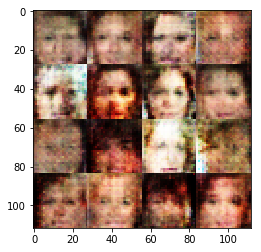

Epoch 1/1... Step 2010 Discriminator Loss: 1.3995... Generator Loss: 0.7960
Epoch 1/1... Step 2020 Discriminator Loss: 1.4007... Generator Loss: 0.8033


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.2
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.